In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. Customer retention has now become even more important than customer acquisition. For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which **customers are at high risk of churn**. Churn prediction is usually more critical (and non-trivial) for prepaid customers.

By reducing churn of the high-value customers, we will be able to reduce significant revenue leakage. In this project, we have defined high-value customers and predict churn only on high-value customers. Here the churn is usage based churn.

**Understanding the business objective and the data** - 
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September.

In this case, the customer churn phases are like this
- The first two months are the ‘good’ phase.
- The third month is the ‘action’ phase
- The fourth month is the ‘churn’ phase.

**The business objective** is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

## Step 1 - Read and Analyse the data

In [1]:
#Import all necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# To view all rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [3]:
# Read the dataset
telecom = pd.read_csv("telecom_churn_data.csv")
telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [4]:
# Checking numbers of rows and columns
telecom.shape

(99999, 226)

In [5]:
# Checking datatypes 
telecom.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    mobile_number             int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    last_date_of_month_9      object 
 9    arpu_6                    float64
 10   arpu_7                    float64
 11   arpu_8                    float64
 12   arpu_9                    float64
 13   onnet_mou_6               float64
 14   onnet_mou_7               float64
 15   onnet_mou_8               float64
 16   onnet_mou_9               float64
 17   offnet_mou_6              float64
 18   offnet_mou_7              float64
 19   offnet_mou_8              float64
 20   offn

In [6]:
# Checking statistical data of all numerical the columns
telecom.describe(include='all')

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999,99398,98899,98340,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000

In [7]:
# create column name list by types of columns
id_cols = ['mobile_number', 'circle_id']

date_cols = ['last_date_of_month_6',
             'last_date_of_month_7',
             'last_date_of_month_8',
             'last_date_of_month_9',
             'date_of_last_rech_6',
             'date_of_last_rech_7',
             'date_of_last_rech_8',
             'date_of_last_rech_9',
             'date_of_last_rech_data_6',
             'date_of_last_rech_data_7',
             'date_of_last_rech_data_8',
             'date_of_last_rech_data_9'
            ]

cat_cols =  ['night_pck_user_6',
             'night_pck_user_7',
             'night_pck_user_8',
             'night_pck_user_9',
             'fb_user_6',
             'fb_user_7',
             'fb_user_8',
             'fb_user_9'
            ]

num_cols = [column for column in telecom.columns if column not in id_cols + date_cols + cat_cols]

# print the number of columns in each list
print("#ID cols: %d\n#Date cols:%d\n#Numeric cols:%d\n#Category cols:%d" % (len(id_cols), len(date_cols), len(num_cols), len(cat_cols)))

# Have all columns been categorised correctly?
print(len(id_cols) + len(date_cols) + len(num_cols) + len(cat_cols) == telecom.shape[1])

#ID cols: 2
#Date cols:12
#Numeric cols:204
#Category cols:8
True


In [8]:
# Checking missing percentage in the dataset
round((telecom.isnull().sum()/len(telecom))*100,2)

mobile_number                0.00
circle_id                    0.00
loc_og_t2o_mou               1.02
std_og_t2o_mou               1.02
loc_ic_t2o_mou               1.02
last_date_of_month_6         0.00
last_date_of_month_7         0.60
last_date_of_month_8         1.10
last_date_of_month_9         1.66
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
arpu_9                       0.00
onnet_mou_6                  3.94
onnet_mou_7                  3.86
onnet_mou_8                  5.38
onnet_mou_9                  7.75
offnet_mou_6                 3.94
offnet_mou_7                 3.86
offnet_mou_8                 5.38
offnet_mou_9                 7.75
roam_ic_mou_6                3.94
roam_ic_mou_7                3.86
roam_ic_mou_8                5.38
roam_ic_mou_9                7.75
roam_og_mou_6                3.94
roam_og_mou_7                3.86
roam_og_mou_8                5.38
roam_og_mou_9                7.75
loc_og_t2t_mou

## Step 2: Missing value treatment and Imputation

### 1. Id, Date and Recharge columns

In [9]:
# To find customers who didn't recharge, we will look at total_rech_data and the last_reach_data value which are missing together
telecom.loc[telecom.total_rech_data_6.isnull() & telecom.date_of_last_rech_data_6.isnull(), ["total_rech_data_6", "date_of_last_rech_data_6"]].head(5)

,total_rech_data_6,date_of_last_rech_data_6
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
5,NaN,NaN
6,NaN,NaN


In [10]:
recharge_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
                 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9',
                 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9',
                 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
                 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9',
                 ]

telecom[recharge_cols].describe(include='all')

,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.00000,25153.000000,25571.000000,26339.000000,25922.000000
mean,2.463802,2.666419,2.651999,2.441170,1.864668,2.044699,2.016288,1.781807,0.599133,0.621720,0.635711,0.659363,126.393392,126.729459,125.717301,124.94144,192.600982,200.981292,197.526489,192.734315
std,2.789128,3.031593,3.074987,2.516339,2.570254,2.768332,2.720132,2.214701,1.274428,1.394524,1.422827,1.411513,108.477235,109.765267,109.437851,111.36376,192.646318,196.791224,191.301305,188.400286
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.500000,0.500000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,25.000000,25.00000,82.000000,92.000000,87.000000,69.000000
50%,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,145.000000,145.000000,145.000000,145.00000,154.000000,154.000000,154.000000,164.000000
75%,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,177.000000,177.000000,179.000000,179.00000,252.000000,252.000000,252.000000,252.000000
max,61.000000,54.000000,60.000000,84.000000,42.000000,48.000000,44.000000,40.000000,29.000000,35.000000,45.000000,49.000000,1555.000000,1555.000000,1555.000000,1555.00000,7546.000000,4365.000000,4076.000000,4061.000000


###### Comment:

We can observe that in the recharge variables has minumum value of 1 which means customer didn't recharge their number in that month so we will impute missing values with zeroes

In [11]:
# creating a list of recharge columns where we will impute missing values with zeroes
recharge_zeros = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
        'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9',
        'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9'
       ]
# impute missing values with 0
telecom[recharge_zeros] = telecom[recharge_zeros].apply(lambda x: x.fillna(0))

In [12]:
# Checking if values are imputed correctly
print("Missing value ratio:\n")
print(telecom[recharge_zeros].isnull().sum()*100/telecom.shape[1])

# Summary
print("\n\nSummary statistics\n")
print(telecom[recharge_zeros].describe(include='all'))

Missing value ratio:

total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
total_rech_data_9     0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
av_rech_amt_data_9    0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
max_rech_data_9       0.0
dtype: float64


Summary statistics

       total_rech_data_6  total_rech_data_7  total_rech_data_8  \
count       99999.000000       99999.000000       99999.000000   
mean            0.619726           0.681837           0.698517   
std             1.760541           1.924382           1.963417   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.000000           0.000000           0.000000   
75%             1.000000           1.000000           1.000000   
max            61.000000          54.000000          60.000000   

       total_rech_data_9  av_rech_

In [13]:
print("Shape before dropping: ", telecom.shape)
telecom = telecom.drop(id_cols + date_cols, axis=1)
print("Shape after dropping: ", telecom.shape)

Shape before dropping:  (99999, 226)
Shape after dropping:  (99999, 212)


### 2. Categorical variables

In [14]:
# Replace missing values with mode of the column
telecom[cat_cols] = telecom[cat_cols].apply(lambda x: x.mode()[0])

In [15]:
print("Missing value percentage:\n")
print(telecom[cat_cols].isnull().sum()*100/telecom.shape[0])

Missing value percentage:

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
night_pck_user_9    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
fb_user_9           0.0
dtype: float64


### 3. Missing values more than 70%

In [16]:
# Removing rows having more than 70% null except the columns having _9
tel_del = pd.DataFrame(telecom.isnull().sum()*100/telecom.shape[0])
tel_del.columns = ['null_val']
del_col = list(tel_del[(tel_del.null_val>70) & (tel_del.index.str.contains('_9')==False)].index)
telecom.drop(del_col,axis=1,inplace=True)
print("list of columns dropped:",del_col)
print("Dimension after dropping columns", telecom.shape)

list of columns dropped: ['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8']
Dimension after dropping columns (99999, 200)


### 4. Numerical columns

In [17]:
# Imputing missing values in numerical rows having more than 70% null except the columns having _9
mean_num_cols = [x for x in num_cols if "_9" not in x]
for items in mean_num_cols:
    try:
        telecom[items].fillna(telecom[items].mean(), inplace=True)
    except:
        continue
        
print("Missing value percentage:\n")
round((telecom.isnull().sum()/len(telecom))*100,2)

Missing value percentage:



loc_og_t2o_mou         0.00
std_og_t2o_mou         0.00
loc_ic_t2o_mou         0.00
arpu_6                 0.00
arpu_7                 0.00
arpu_8                 0.00
arpu_9                 0.00
onnet_mou_6            0.00
onnet_mou_7            0.00
onnet_mou_8            0.00
onnet_mou_9            7.75
offnet_mou_6           0.00
offnet_mou_7           0.00
offnet_mou_8           0.00
offnet_mou_9           7.75
roam_ic_mou_6          0.00
roam_ic_mou_7          0.00
roam_ic_mou_8          0.00
roam_ic_mou_9          7.75
roam_og_mou_6          0.00
roam_og_mou_7          0.00
roam_og_mou_8          0.00
roam_og_mou_9          7.75
loc_og_t2t_mou_6       0.00
loc_og_t2t_mou_7       0.00
loc_og_t2t_mou_8       0.00
loc_og_t2t_mou_9       7.75
loc_og_t2m_mou_6       0.00
loc_og_t2m_mou_7       0.00
loc_og_t2m_mou_8       0.00
loc_og_t2m_mou_9       7.75
loc_og_t2f_mou_6       0.00
loc_og_t2f_mou_7       0.00
loc_og_t2f_mou_8       0.00
loc_og_t2f_mou_9       7.75
loc_og_t2c_mou_6    

In [18]:
print("Shape after dropping: ", telecom.shape)

Shape after dropping:  (99999, 200)


## Step 3: - Data Preparation

### 1. Filtering HVC ( High Valued Customers)

In [19]:
# Creating data recharge columns for June and July
telecom['total_data_rech_6'] = telecom.total_rech_data_6 * telecom.av_rech_amt_data_6
telecom['total_data_rech_7'] = telecom.total_rech_data_7 * telecom.av_rech_amt_data_7

In [20]:
# calculate total recharge amount for June and July
telecom['amt_data_6'] = telecom.total_rech_amt_6 + telecom.total_data_rech_6
telecom['amt_data_7'] = telecom.total_rech_amt_7 + telecom.total_data_rech_7

In [21]:
# calculate average recharge done by customer in June and July
telecom['av_amt_data_6_7'] = (telecom.amt_data_6 + telecom.amt_data_7)/2

# Filtering the high value customers i.e, average recharge after 70th quantile
telco_filtered = telecom.loc[telecom.av_amt_data_6_7 >= telecom.av_amt_data_6_7.quantile(0.7), :]
telco_filtered = telco_filtered.reset_index(drop=True)
telco_filtered.shape

(30001, 205)

In [22]:
# Dropping the recharge columns for June and July after filtering high value customers
telco_filtered = telco_filtered.drop(['total_data_rech_6', 'total_data_rech_7',
                                      'amt_data_6', 'amt_data_7', 'av_amt_data_6_7'], axis=1)
telco_filtered.shape

(30001, 200)

### 2 - Deriving Variables

##### 2.1:  Deriving churn

In [23]:
# Deriving churn if usage in september is zero
telco_filtered['churn'] = np.where(telco_filtered[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1) == 0,1,0)
telco_filtered.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_9,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_9,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
0,0.0,0.0,0.0,197.385,214.816,213.803,21.100,132.395875,133.670805,0.00,NaN,197.935577,197.045133,0.00,NaN,9.950013,7.149898,0.00,NaN,13.911337,9.818732,0.00,NaN,47.100763,46.47301,0.00,NaN,93.342088,91.397131,0.00,NaN,3.751013,3.792985,0.00,NaN,1.123056,1.3685,0.00,NaN,144.201175,141.670476,0.00,NaN,79.82987,83.299598,0.00,NaN,87.299624,90.804137,0.00,NaN,1.129011,1.11501,0.00,NaN,0.0,0.0,0.0,NaN,168.261218,175.221436,0.00,NaN,0.798277,0.776572,0.00,NaN,3.916811,4.978279,0.00,NaN,0.454157,0.030235,0.0,NaN,0.00,0.00,0.00,0.00,47.922365,47.99052,0.16,NaN,107.47565,107.120493,4.13,NaN,12.084305,12.599697,1.15,NaN,167.491059,167.71954,5.44,NaN,9.575993,10.011904,0.00,NaN,20.72224,21.656415,0.00,NaN,2.156397,2.216923,0.00,NaN,0.0,0.0,0.0,NaN,32.457179,33.887833,0.00,NaN,0.00,0.00,5.44,0.00,0.061557,0.033585,0.0,NaN,7.460608,8.334936,0.00,NaN,0.854656,1.01296,0.00,NaN,4,3,2,6,362,252,252,0,252,252,252,0,252,252,252,0,1.0,1.0,1.0,0.0,252.0,252.0,252.0,0.0,NaN,NaN,252.0,252.0,252.0,0.0,30.13,1.32,5.75,0.00,83.57,150.76,109.61,0.00,NaN,NaN,0.0,0.0,0.0,0.0,0,0,

In [24]:
# lets find out churn/non churn percentage
telco_filtered['churn'].value_counts()/len(telco_filtered)*100

0    91.863605
1     8.136395
Name: churn, dtype: float64

##### 2.2:  Deriving new variable
- Let's create a difference variable by taking difference between August and average of June and July

In [25]:
telco_filtered['arpu_diff'] = telco_filtered.arpu_8 - ((telco_filtered.arpu_6 + telco_filtered.arpu_7)/2)

telco_filtered['onnet_mou_diff'] = telco_filtered.onnet_mou_8 - ((telco_filtered.onnet_mou_6 + telco_filtered.onnet_mou_7)/2)

telco_filtered['offnet_mou_diff'] = telco_filtered.offnet_mou_8 - ((telco_filtered.offnet_mou_6 + telco_filtered.offnet_mou_7)/2)

telco_filtered['roam_ic_mou_diff'] = telco_filtered.roam_ic_mou_8 - ((telco_filtered.roam_ic_mou_6 + telco_filtered.roam_ic_mou_7)/2)

telco_filtered['roam_og_mou_diff'] = telco_filtered.roam_og_mou_8 - ((telco_filtered.roam_og_mou_6 + telco_filtered.roam_og_mou_7)/2)

telco_filtered['loc_og_mou_diff'] = telco_filtered.loc_og_mou_8 - ((telco_filtered.loc_og_mou_6 + telco_filtered.loc_og_mou_7)/2)

telco_filtered['std_og_mou_diff'] = telco_filtered.std_og_mou_8 - ((telco_filtered.std_og_mou_6 + telco_filtered.std_og_mou_7)/2)

telco_filtered['isd_og_mou_diff'] = telco_filtered.isd_og_mou_8 - ((telco_filtered.isd_og_mou_6 + telco_filtered.isd_og_mou_7)/2)

telco_filtered['spl_og_mou_diff'] = telco_filtered.spl_og_mou_8 - ((telco_filtered.spl_og_mou_6 + telco_filtered.spl_og_mou_7)/2)

telco_filtered['total_og_mou_diff'] = telco_filtered.total_og_mou_8 - ((telco_filtered.total_og_mou_6 + telco_filtered.total_og_mou_7)/2)

telco_filtered['loc_ic_mou_diff'] = telco_filtered.loc_ic_mou_8 - ((telco_filtered.loc_ic_mou_6 + telco_filtered.loc_ic_mou_7)/2)

telco_filtered['std_ic_mou_diff'] = telco_filtered.std_ic_mou_8 - ((telco_filtered.std_ic_mou_6 + telco_filtered.std_ic_mou_7)/2)

telco_filtered['isd_ic_mou_diff'] = telco_filtered.isd_ic_mou_8 - ((telco_filtered.isd_ic_mou_6 + telco_filtered.isd_ic_mou_7)/2)

telco_filtered['spl_ic_mou_diff'] = telco_filtered.spl_ic_mou_8 - ((telco_filtered.spl_ic_mou_6 + telco_filtered.spl_ic_mou_7)/2)

telco_filtered['total_ic_mou_diff'] = telco_filtered.total_ic_mou_8 - ((telco_filtered.total_ic_mou_6 + telco_filtered.total_ic_mou_7)/2)

telco_filtered['total_rech_num_diff'] = telco_filtered.total_rech_num_8 - ((telco_filtered.total_rech_num_6 + telco_filtered.total_rech_num_7)/2)

telco_filtered['total_rech_amt_diff'] = telco_filtered.total_rech_amt_8 - ((telco_filtered.total_rech_amt_6 + telco_filtered.total_rech_amt_7)/2)

telco_filtered['max_rech_amt_diff'] = telco_filtered.max_rech_amt_8 - ((telco_filtered.max_rech_amt_6 + telco_filtered.max_rech_amt_7)/2)

telco_filtered['total_rech_data_diff'] = telco_filtered.total_rech_data_8 - ((telco_filtered.total_rech_data_6 + telco_filtered.total_rech_data_7)/2)

telco_filtered['max_rech_data_diff'] = telco_filtered.max_rech_data_8 - ((telco_filtered.max_rech_data_6 + telco_filtered.max_rech_data_7)/2)

telco_filtered['av_rech_amt_data_diff'] = telco_filtered.av_rech_amt_data_8 - ((telco_filtered.av_rech_amt_data_6 + telco_filtered.av_rech_amt_data_7)/2)

telco_filtered['vol_2g_mb_diff'] = telco_filtered.vol_2g_mb_8 - ((telco_filtered.vol_2g_mb_6 + telco_filtered.vol_2g_mb_7)/2)

telco_filtered['vol_3g_mb_diff'] = telco_filtered.vol_3g_mb_8 - ((telco_filtered.vol_3g_mb_6 + telco_filtered.vol_3g_mb_7)/2)


In [26]:
# Summary of one of the derived variables
telco_filtered['vol_3g_mb_diff'].describe()

count    30001.000000
mean        -5.733637
std        624.877555
min     -12385.505000
25%         -2.270000
50%          0.000000
75%          0.000000
max      15646.390000
Name: vol_3g_mb_diff, dtype: float64

### 3. Dropping columns that belong to September ( Churn month)

In [27]:
# filtering out all columns where 9 is present
telco_filtered = telco_filtered.filter(regex='[^9]$', axis=1)

In [28]:
# extract all names that end with 9
col_9_names = telecom.filter(regex='9$', axis=1).columns

# update num_cols and cat_cols column name list
cat_cols = [col for col in cat_cols if col not in col_9_names]
cat_cols.append('churn')
num_cols = [col for col in telco_filtered.columns if col not in cat_cols]

In [29]:
# Checking for any missing values
telco_filtered.isnull().sum()/len(telco_filtered)

loc_og_t2o_mou           0.0
std_og_t2o_mou           0.0
loc_ic_t2o_mou           0.0
arpu_6                   0.0
arpu_7                   0.0
arpu_8                   0.0
onnet_mou_6              0.0
onnet_mou_7              0.0
onnet_mou_8              0.0
offnet_mou_6             0.0
offnet_mou_7             0.0
offnet_mou_8             0.0
roam_ic_mou_6            0.0
roam_ic_mou_7            0.0
roam_ic_mou_8            0.0
roam_og_mou_6            0.0
roam_og_mou_7            0.0
roam_og_mou_8            0.0
loc_og_t2t_mou_6         0.0
loc_og_t2t_mou_7         0.0
loc_og_t2t_mou_8         0.0
loc_og_t2m_mou_6         0.0
loc_og_t2m_mou_7         0.0
loc_og_t2m_mou_8         0.0
loc_og_t2f_mou_6         0.0
loc_og_t2f_mou_7         0.0
loc_og_t2f_mou_8         0.0
loc_og_t2c_mou_6         0.0
loc_og_t2c_mou_7         0.0
loc_og_t2c_mou_8         0.0
loc_og_mou_6             0.0
loc_og_mou_7             0.0
loc_og_mou_8             0.0
std_og_t2t_mou_6         0.0
std_og_t2t_mou

###### Comment:
There are no missing values

In [30]:
# change columns types
telco_filtered[num_cols] = telco_filtered[num_cols].apply(pd.to_numeric)
telco_filtered[cat_cols] = telco_filtered[cat_cols].apply(lambda column: column.astype("category"), axis=0)

In [31]:
# Dropping records where there is only 1 unique value as it will not add any extra info to the model
for i in telco_filtered.columns:
    if telco_filtered[i].nunique() == 1:
        print("\nColumn",i,"has no variance and contains only",telco_filtered[i].nunique(),"unique value")
        print("Dropping the column",i)
        telco_filtered.drop(i,axis=1, inplace = True)


Column loc_og_t2o_mou has no variance and contains only 1 unique value
Dropping the column loc_og_t2o_mou

Column std_og_t2o_mou has no variance and contains only 1 unique value
Dropping the column std_og_t2o_mou

Column loc_ic_t2o_mou has no variance and contains only 1 unique value
Dropping the column loc_ic_t2o_mou

Column std_og_t2c_mou_6 has no variance and contains only 1 unique value
Dropping the column std_og_t2c_mou_6

Column std_og_t2c_mou_7 has no variance and contains only 1 unique value
Dropping the column std_og_t2c_mou_7

Column std_og_t2c_mou_8 has no variance and contains only 1 unique value
Dropping the column std_og_t2c_mou_8

Column std_ic_t2o_mou_6 has no variance and contains only 1 unique value
Dropping the column std_ic_t2o_mou_6

Column std_ic_t2o_mou_7 has no variance and contains only 1 unique value
Dropping the column std_ic_t2o_mou_7

Column std_ic_t2o_mou_8 has no variance and contains only 1 unique value
Dropping the column std_ic_t2o_mou_8

Column night

In [32]:
telco_filtered.shape

(30001, 158)

## Step 4: EDA 

### 4.1: Univariate Analysis

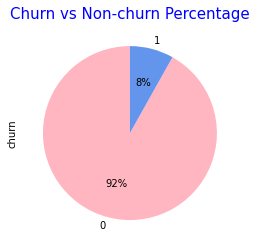

In [33]:
telco_filtered.churn.value_counts().plot(kind = 'pie', autopct = '%1.0f%%', colors = ['lightpink','cornflowerblue'], startangle = 90)
plt.title("Churn vs Non-churn Percentage", fontdict = {'color' :'blue', 'fontsize':15} );

##### Comment:
8% of the customers churned and 92% did not move to new network


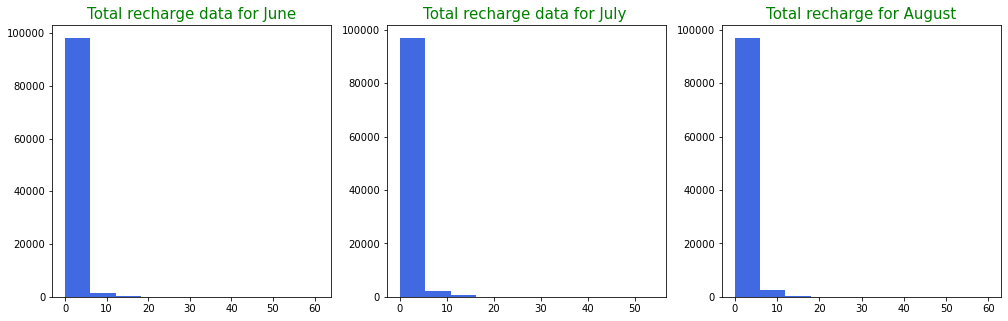

In [34]:
plt.figure(figsize = (17,5))

plt.subplot(1,3,1)
plt.hist(telecom['total_rech_data_6'], color = 'royalblue')
plt.title("Total recharge data for June", fontdict = {'color' :'green', 'fontsize':15});

plt.subplot(1,3,2)
plt.hist(telecom['total_rech_data_7'],color = 'royalblue')
plt.title("Total recharge data for July ",fontdict = {'color' :'green', 'fontsize':15})

plt.subplot(1,3,3)
plt.hist(telecom['total_rech_data_8'],color = 'royalblue')
plt.title("Total recharge for August",fontdict = {'color' :'green', 'fontsize':15});



###### Comment:
Variables are skewed towards left

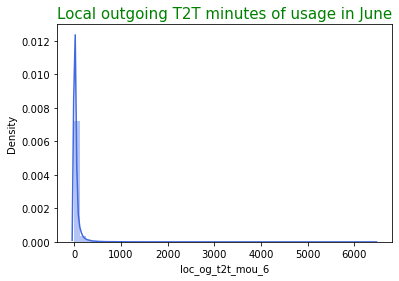

In [35]:
sns.distplot(telecom['loc_og_t2t_mou_6'],color = 'royalblue')
plt.title("Local outgoing T2T minutes of usage in June", fontdict = {'color' :'green', 'fontsize':15});

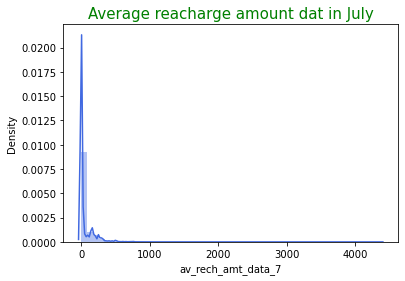

In [36]:
sns.distplot(telecom['av_rech_amt_data_7'],color = 'royalblue')
plt.title("Average reacharge amount dat in July", fontdict = {'color' :'green', 'fontsize':15});

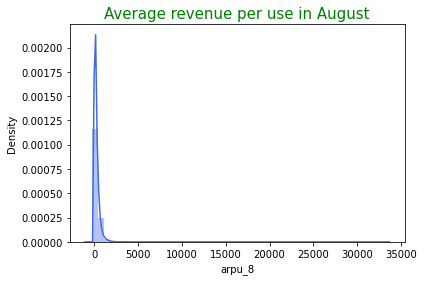

In [37]:
sns.distplot(telecom['arpu_8'],color = 'royalblue')
plt.title("Average revenue per use in August", fontdict = {'color' :'green', 'fontsize':15});

###### Comment:
Variables are skewed towards the left

### 4.2: Bivariate Analysis

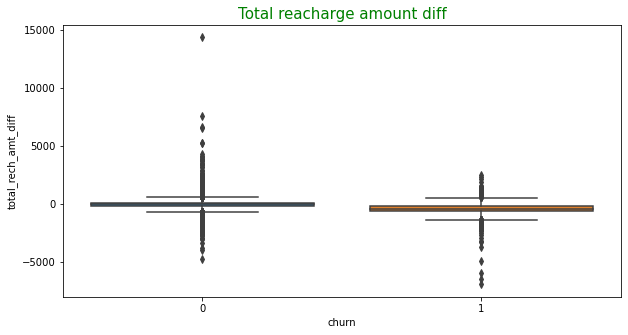

In [38]:
plt.figure(figsize = (10,5))
sns.boxplot(telco_filtered['churn'],telco_filtered['total_rech_amt_diff'])
plt.title("Total reacharge amount diff", fontdict = {'color' :'green', 'fontsize':15});

###### Comment:

We can see that customers who churned had negative balance

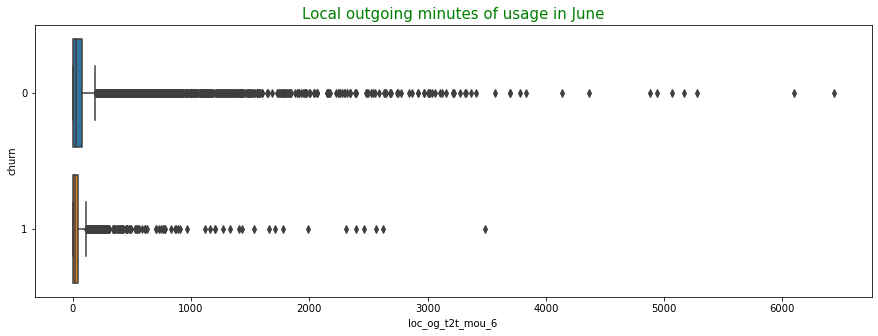

In [39]:
plt.figure(figsize = (15,5))
sns.boxplot(telco_filtered['loc_og_t2t_mou_6'], telco_filtered['churn'])
plt.title("Local outgoing minutes of usage in June", fontdict = {'color' :'green', 'fontsize':15});

###### Comment:
Customers who churned made Local outgoing calls below 2000 minutes

### 4.3: Multivariate Analysis

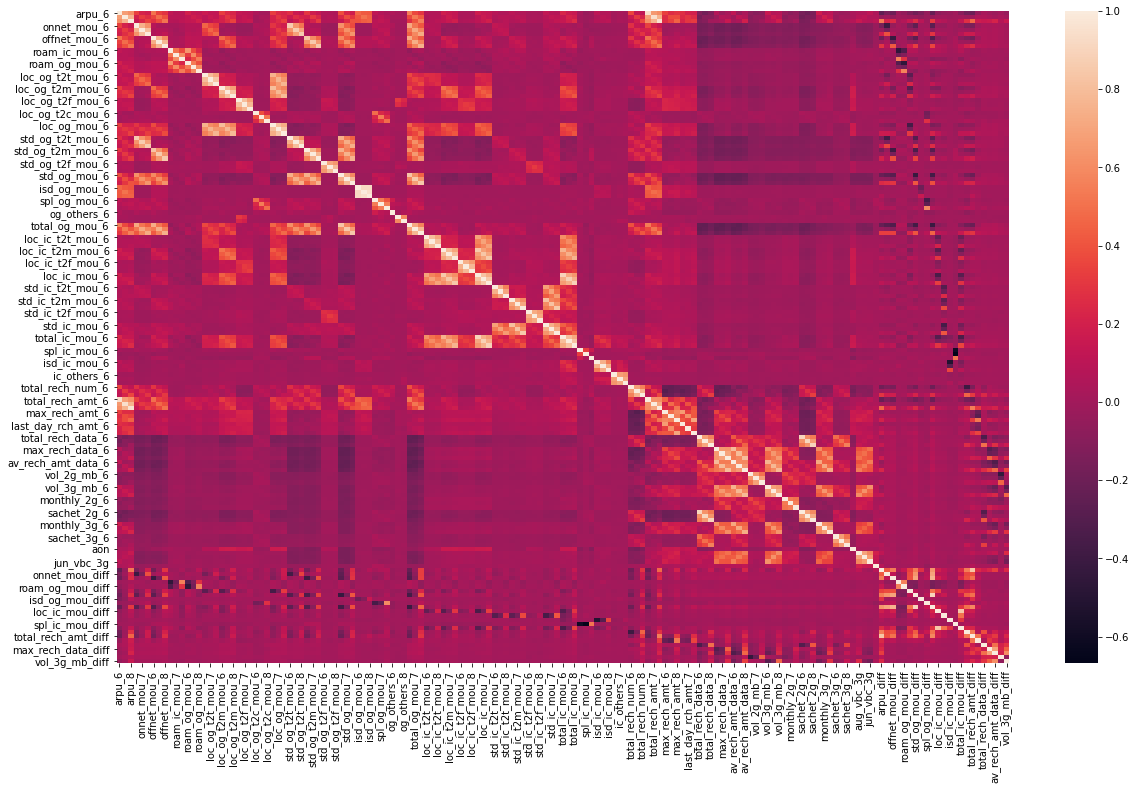

In [40]:
plt.figure(figsize=(20,12))
sns.heatmap(telco_filtered.corr());

###### Comment:

From the above heatmap, we can see there is presence of multicollinearity among many variables

## Step 5 - Outlier Detection and Treatment

In [41]:
diff_cols = telco_filtered.filter(regex = 'diff$',axis = 1)

In [42]:
diff_cols.describe()

,arpu_diff,onnet_mou_diff,offnet_mou_diff,roam_ic_mou_diff,roam_og_mou_diff,loc_og_mou_diff,std_og_mou_diff,isd_og_mou_diff,spl_og_mou_diff,total_og_mou_diff,loc_ic_mou_diff,std_ic_mou_diff,isd_ic_mou_diff,spl_ic_mou_diff,total_ic_mou_diff,total_rech_num_diff,total_rech_amt_diff,max_rech_amt_diff,total_rech_data_diff,max_rech_data_diff,av_rech_amt_data_diff,vol_2g_mb_diff,vol_3g_mb_diff
count,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000
mean,-51.038557,-27.387222,-36.690499,-1.744854,-3.320213,-15.917399,-44.455951,-0.172902,0.211379,-67.437337,-5.936305,-2.816804,-0.143993,-0.013113,-13.430810,-1.812056,-76.249725,-10.598813,-0.138845,-6.467768,-13.085795,-19.896683,-5.733637
std,334.872321,307.159714,346.339723,65.940293,94.116788,212.652302,425.190385,13.994039,18.054914,502.630069,179.344968,98.075430,56.698339,0.174464,221.899902,6.755899,418.479122,136.893018,2.214561,78.343307,148.249896,256.114926,624.877555
min,-5811.052500,-5295.315000,-7094.390000,-1296.985000,-2410.835000,-3867.830000,-7127.425000,-618.858753,-1081.910000,-7213.410000,-3673.622425,-2777.350000,-5534.595000,-16.280000,-5710.150000,-147.500000,-6950.000000,-3010.000000,-30.500000,-1303.000000,-3486.500000,-4740.925000,-12385.505000
25%,-180.179500,-53.245000,-98.967789,0.000000,0.000000,-59.105000,-57.605000,0.000000,-2.685000,-168.025000,-49.350000,-11.965000,0.000000,0.000000,-67.230000,-4.000000,-245.000000,-33.000000,-0.500000,-7.000000,-59.000000,-21.120000,-2.270000
50%,-40.754500,-2.880000,-10.280000,0.000000,0.000000,-4.155000,-0.360000,0.000000,0.000000,-14.625000,-2.870000,-0.530000,0.000000,0.000000,-5.610000,-1.500000,-57.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,83.239000,23.205000,47.375000,0.000000,0.000000,36.115000,12.275000,0.000000,1.800000,67.915000,40.260000,6.535000,0.000000,0.000000,44.280000,1.000000,99.500000,25.000000,0.000000,0.000000,9.500000,0.000000,0.000000
max,12808.617000,6359.920000,12604.240000,2330.200000,3057.150000,4619.975000,12715.480000,544.780000,747.620000,12768.705000,3485.370000,3321.395000,3163.690000,4.450000,3485.370000,130.500000,14344.500000,3949.000000,52.500000,1352.000000,1805.000000,8062.295000,15646.390000


In [43]:
for item in diff_cols:
    telco_filtered = telco_filtered[telco_filtered[item] < np.percentile(telco_filtered[item],100)]

In [44]:
# Shape of the dataset after dropping the 100th percentile
telco_filtered.shape

(29978, 158)

In [45]:
# Verifying if 100th percentile was removed
telco_filtered.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,arpu_diff,onnet_mou_diff,offnet_mou_diff,roam_ic_mou_diff,roam_og_mou_diff,loc_og_mou_diff,std_og_mou_diff,isd_og_mou_diff,spl_og_mou_diff,total_og_mou_diff,loc_ic_mou_diff,std_ic_mou_diff,isd_ic_mou_diff,spl_ic_mou_diff,total_ic_mou_diff,total_rech_num_diff,total_rech_amt_diff,max_rech_amt_diff,total_rech_data_diff,max_rech_data_diff,av_rech_amt_data_diff,vol_2g_mb_diff,vol_3g_mb_diff
count,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,29978.000000,299

## Step 6 - Data Preparation for Model Building

##### 6.1 - Creating X and y variables

In [46]:
# lets create X & y dataset for model building
X = telco_filtered.drop(['churn'], axis=1)
y = telco_filtered['churn']

##### 6.2 - Train, test , Split

In [47]:
# split the dateset into train and test datasets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)
print("Dimension of X_tr:", X_tr.shape)
print("Dimension of X_test:", X_test.shape)

Dimension of X_tr: (20984, 157)
Dimension of X_test: (8994, 157)


##### 6.3 - Using SMOTE to handle class imbalance in the datasmet.
- From EDA we can see there is 91: 8 ratio for non-churn and churn

In [48]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_train,y_train = sm.fit_sample(X_tr,y_tr)

In [49]:
print("Dimension of X_train Shape:", X_train.shape)
print("Dimension of y_train Shape:", y_train.shape)

print("Imbalance in Training dataset:",(y_train != 0).sum()/(y_train == 0).sum())

Dimension of X_train Shape: (38530, 157)
Dimension of y_train Shape: (38530,)
Imbalance in Training dataset: 1.0


##### 6.4 - Scaling and PCA
We will now go ahead and applying scaling to build model and apply PCA as there are 150+ variables and to handle multicollinearity

In [50]:
# Applying scaling and PCA using pipeline.
pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])
pca.fit(X_train)
churn_pca = pca.fit_transform(X_train)

In [51]:
# Extract pca model from pipeline
pca = pca.named_steps['pca']

# Checking explainded variance of PCA components
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0        8.80
1       17.44
2       22.87
3       27.74
4       31.44
5       34.98
6       37.88
7       40.58
8       43.20
9       45.58
10      47.79
11      49.81
12      51.70
13      53.53
14      55.32
15      56.99
16      58.63
17      60.19
18      61.73
19      63.20
20      64.65
21      66.00
22      67.30
23      68.56
24      69.78
25      70.96
26      72.14
27      73.22
28      74.28
29      75.27
30      76.22
31      77.17
32      78.07
33      78.92
34      79.72
35      80.51
36      81.26
37      81.99
38      82.69
39      83.38
40      84.05
41      84.69
42      85.31
43      85.91
44      86.47
45      87.02
46      87.53
47      88.05
48      88.50
49      88.94
50      89.35
51      89.76
52      90.16
53      90.53
54      90.90
55      91.25
56      91.60
57      91.95
58      92.28
59      92.60
60      92.92
61      93.23
62      93.53
63      93.81
64      94.09
65      94.36
66      94.62
67      94.88
68      95.13
69      95.37
70      95.60
71    

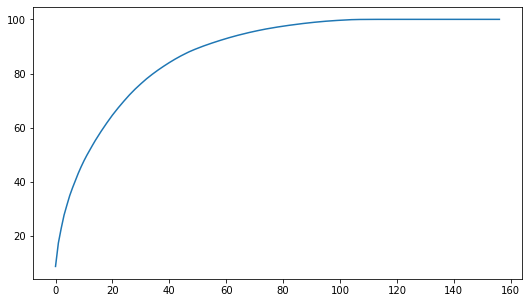

In [52]:
# plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(175/20,100/20)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)

## Step 7 : Model Building 

### 7.1 - Logistic Regression

In [53]:
# Creating and combining pipeline for scaling, PCA and LR
PCA_VARS = 60
steps = [('scaler', StandardScaler()),
         ("pca", PCA(n_components=PCA_VARS)),
         ("logistic", LogisticRegression(class_weight='balanced'))
        ]
pipeline = Pipeline(steps)

In [54]:
# fit model
pipeline.fit(X_train, y_train)

# check score on train data
pipeline.score(X_train, y_train)

0.8455229691149754

In [55]:
# predict churn on test data
y_pred = pipeline.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[6748 1528]
 [ 161  557]]
Sensitivity: 	0.78
Specificity: 	0.82
AUC:    	 0.87


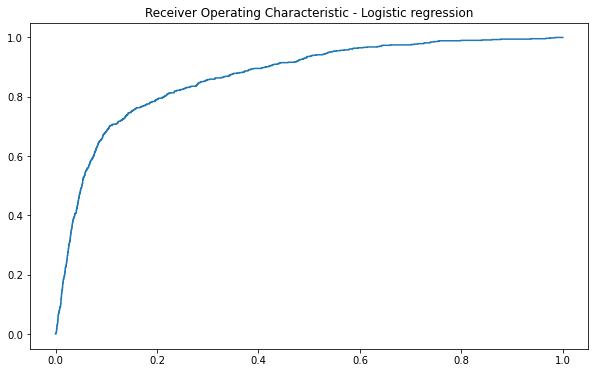

In [56]:
# Plot ROC curve
plt.figure(figsize=(10,6))
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_prob)
plt.title('Receiver Operating Characteristic - Logistic regression')
plt.ylabel="True Positive Rate"
plt.xlabel="False Positive Rate"
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

#### 7.2 - Tuning hyperparameters

In [57]:
# PCA
pca = PCA()

# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight={0:0.1, 1: 0.9})

# create pipeline
steps = [("scaler", StandardScaler()), 
         ("pca", pca),
         ("logistic", logistic)
        ]

# compile pipeline
pca_logistic = Pipeline(steps)

# hyperparameter space
params = {'pca__n_components': [60, 75, 80], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [58]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2'],
                         'pca__n_components': [60, 75, 80]},
             scoring='roc_auc', verbose=1)

In [59]:
# cross validation results
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.896412,0.152551,0.000000,0.000000,0.1,l1,60,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,48
1,4.704366,0.691224,0.000000,0.000000,0.1,l1,75,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
2,4.715344,0.552690,0.000000,0.000000,0.1,l1,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,34
3,4.331618,0.278816,0.116289,0.010300,0.1,l2,60,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.907480,0.907655,0.914380,0.912814,0.899585,0.908383,0.005184,18
4,4.845608,0.387688,0.111899,0.023898,0.1,l2,75,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.910153,0.911599,0.919537,0.918849,0.903836,0.912795,0.005844,1
5,5.276170,0.263308,0.106828,0.011694,0.1,l2,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.909539,0.910984,0.919608,0.919069,0.903864,0.912613,0.005988,4
6,3.357205,0.148210,0.000000,0.000000,0.5,l1,60,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,28
7,4.112807,0.213570,0.000000,0.000000,0.5,l1,75,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,37
8,4.353747,0.272806,0.000000,0.000000,0.5,l1,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,38
9,4.314158,0.282267,0.098537,0.010524,0.5,l2,60,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.906939,0.907166,0.914689,0.913914,0.898713,0.908284,0.005786,19


In [60]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.912794685620509
Best hyperparameters:  {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'pca__n_components': 75}


In [61]:
# predict churn on test data
y_pred = model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[3847 4429]
 [  37  681]]
Sensitivity: 	0.95
Specificity: 	0.46
AUC:    	 0.86


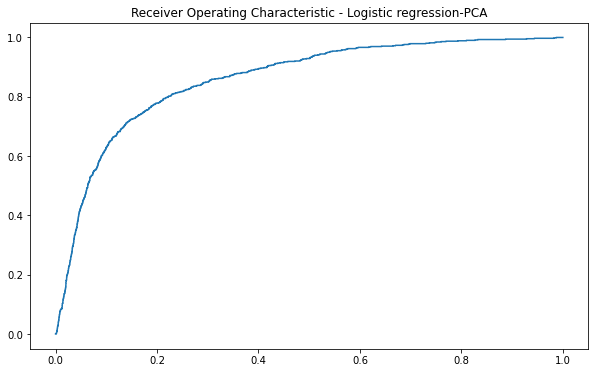

In [62]:
plt.figure(figsize=(10,6))
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_prob)
plt.title('Receiver Operating Characteristic - Logistic regression-PCA')
plt.ylabel="True Positive Rate"
plt.xlabel="False Positive Rate"
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

### 7.2 - Random Forest

In [63]:
# Random forest - the class weight is used to handle class imbalance - it adjusts the cost function
forest = RandomForestClassifier(class_weight={0:0.1, 1: 0.9}, n_jobs = -1)

# hyperparameter space
params = {"criterion": ['gini', 'entropy'], "max_features": ['auto', 0.4]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=forest, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [64]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=RandomForestClassifier(class_weight={0: 0.1, 1: 0.9},
                                              n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 0.4]},
             scoring='roc_auc', verbose=1)

In [65]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.9945145732990813
Best hyperparameters:  {'criterion': 'entropy', 'max_features': 'auto'}


In [66]:
# predict churn on test data
y_pred = model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
specificity= cm[0,0]/(cm[0,0]+cm[0,1])
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[7981  295]
 [ 288  430]]
Sensitivity: 	0.6
Specificity: 	0.96
AUC:    	 0.92


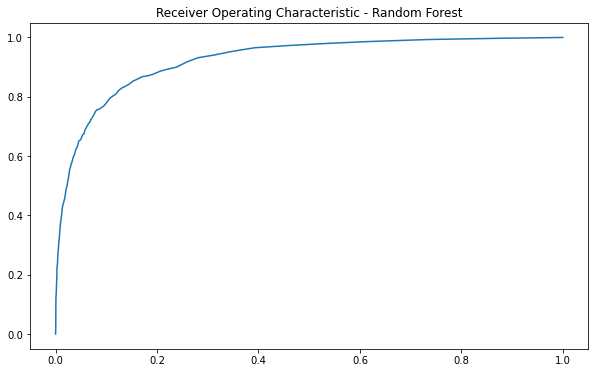

In [67]:
plt.figure(figsize=(10,6))
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_prob)
plt.title('Receiver Operating Characteristic - Random Forest')
plt.ylabel="True Positive Rate"
plt.xlabel="False Positive Rate"
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

In [68]:
# run a random forest model on train data
max_features = int(round(np.sqrt(X_train.shape[1])))    # number of variables to consider to split each node
print(max_features)

rf_model = RandomForestClassifier(n_estimators=100, max_features=max_features, class_weight={0:0.1, 1: 0.9}, oob_score=True, random_state=4, verbose=1)

13


In [69]:
# fit model
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   39.1s finished


RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_features=13,
                       oob_score=True, random_state=4, verbose=1)

In [70]:
# OOB score
rf_model.oob_score_

0.9653516740202439

In [71]:
# predict churn on test data
y_pred = rf_model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[[7959  317]
 [ 308  410]]
Sensitivity: 	0.57
Specificity: 	0.96


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ROC:    	 0.92


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


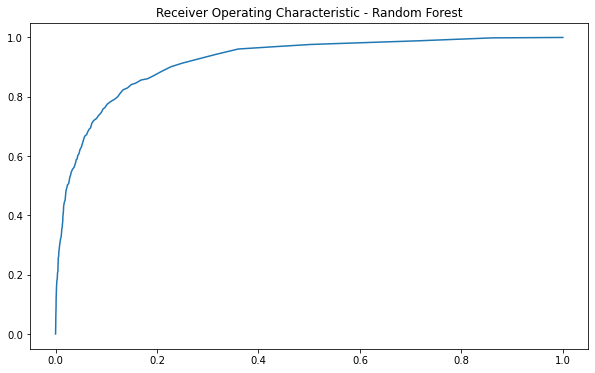

In [72]:
plt.figure(figsize=(10,6))
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_prob)
plt.title('Receiver Operating Characteristic - Random Forest')
plt.ylabel="True Positive Rate"
plt.xlabel="False Positive Rate"
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

In [73]:
# Extracting predictors
features = telco_filtered.drop('churn', axis=1).columns

# feature_importance
importance = rf_model.feature_importances_

# create dataframe
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': importance*100})
feature_importance = feature_importance[['variables', 'importance_percentage']]

# sort features
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
print("Sum of importance=", feature_importance.importance_percentage.sum())
feature_importance

Sum of importance= 100.0


,variables,importance_percentage
0,roam_og_mou_8,7.314394
1,roam_ic_mou_8,6.087638
2,total_ic_mou_8,2.517495
3,total_rech_amt_diff,2.045922
4,loc_og_mou_8,2.042106
5,roam_og_mou_diff,1.987246
6,last_day_rch_amt_8,1.803098
7,loc_ic_mou_8,1.749846
8,loc_ic_t2m_mou_8,1.719330
9,arpu_diff,1.693107


## Step 8: Extracting top 30 features

In [74]:
# extract top 'n' features
top_n = 30
top_features = feature_importance.variables[0:top_n]

In [75]:
import seaborn as sns

<AxesSubplot:>

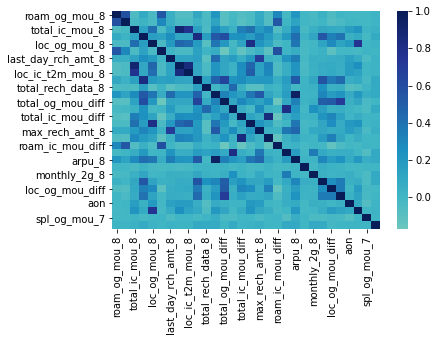

In [76]:
sns.heatmap(data=telco_filtered[top_features].corr(), center=0.0, cmap='YlGnBu')

In [77]:
list(top_features)

['roam_og_mou_8',
 'roam_ic_mou_8',
 'total_ic_mou_8',
 'total_rech_amt_diff',
 'loc_og_mou_8',
 'roam_og_mou_diff',
 'last_day_rch_amt_8',
 'loc_ic_mou_8',
 'loc_ic_t2m_mou_8',
 'arpu_diff',
 'total_rech_data_8',
 'total_rech_amt_8',
 'total_og_mou_diff',
 'av_rech_amt_data_8',
 'total_ic_mou_diff',
 'loc_og_t2m_mou_8',
 'max_rech_amt_8',
 'loc_ic_mou_diff',
 'roam_ic_mou_diff',
 'max_rech_data_8',
 'arpu_8',
 'spl_ic_mou_diff',
 'monthly_2g_8',
 'total_rech_num_diff',
 'loc_og_mou_diff',
 'onnet_mou_diff',
 'aon',
 'loc_og_t2t_mou_8',
 'spl_og_mou_7',
 'vol_2g_mb_diff']

In [78]:
# creating x_tr and x_test using the top features
X_tr = X_tr[list(top_features)]
X_test = X_test[list(top_features)]

## Step 9 -  Final Model

In [79]:
# logistic regression
steps = [('scaler', StandardScaler()), 
         ("logistic", LogisticRegression(class_weight={0:0.1, 1:0.9}))
        ]

# compile pipeline
logistic = Pipeline(steps)

# hyperparameter space
params = {'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [80]:
# fit model
model.fit(X_tr, y_tr)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [81]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.8944335473121591
Best hyperparameters:  {'logistic__C': 10, 'logistic__penalty': 'l2'}


In [82]:
# predict churn on test data
y_pred = model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[7132 1144]
 [ 156  562]]
Sensitivity: 	0.78
Specificity: 	0.86
ROC:    	 0.88


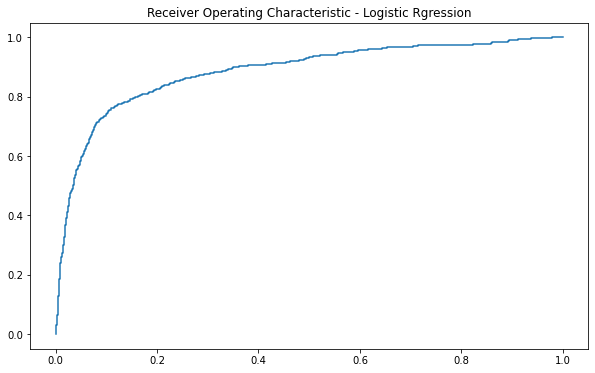

In [83]:
plt.figure(figsize=(10,6))
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_prob)
plt.title('Receiver Operating Characteristic - Logistic Rgression')
plt.ylabel="True Positive Rate"
plt.xlabel="False Positive Rate"
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

In [84]:
final_model = model.best_estimator_.named_steps['logistic']

In [87]:
# intercept
final_model_intercept = pd.DataFrame(final_model.intercept_.reshape((1,1)), columns = ['intercept'])
coefficients =final_model.coef_.reshape((30, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 2) for coefficient in coefficients]
top_features = list(X_tr.columns)
model_coefficients = pd.DataFrame(final_model.coef_, columns=top_features)

In [88]:
# concatenate dataframes
predictor_coeffs = pd.concat([final_model_intercept, model_coefficients], axis=1)
predictor_coeffs

,intercept,roam_og_mou_8,roam_ic_mou_8,total_ic_mou_8,total_rech_amt_diff,loc_og_mou_8,roam_og_mou_diff,last_day_rch_amt_8,loc_ic_mou_8,loc_ic_t2m_mou_8,arpu_diff,total_rech_data_8,total_rech_amt_8,total_og_mou_diff,av_rech_amt_data_8,total_ic_mou_diff,loc_og_t2m_mou_8,max_rech_amt_8,loc_ic_mou_diff,roam_ic_mou_diff,max_rech_data_8,arpu_8,spl_ic_mou_diff,monthly_2g_8,total_rech_num_diff,loc_og_mou_diff,onnet_mou_diff,aon,loc_og_t2t_mou_8,spl_og_mou_7,vol_2g_mb_diff
0,-1.691174,0.257981,0.101187,-2.889931,-0.198049,-1.004489,-0.138031,-0.364144,1.813377,-0.073819,-0.044785,-0.670923,-0.251976,-0.274508,0.119325,-0.643146,0.259971,0.415063,0.329641,-0.078024,-0.332974,0.151712,-0.186249,-0.355134,-0.207562,0.101614,0.019388,-0.230689,0.371644,0.052938,-0.123274


### Summary of the analysis

We started the analysis by seperating Id, date, numerical and categorical columns. Features with more than **70% missing values were dropped** and the others were imputed after analysing them. Next, **High value customers** were filtered as the buisnesss goal is to retain such customers. **Churn is derived** from columns where usage in the month of september is zero.
A new variable is created by taking difference of information from the month of June,July and August. Columns belonging to september were dropped after derving churn from these columns. EDA is performed on few columns and we can confirm the presence of skewness and multicollinearity. Outliers were detected and capped at 100th percentile. Using **SMOTE** we have handled class imbalance. In order to reduce dimensions and multicollinearity, we have scaled the data and performed **PCA** on it. We have built few Logistic Regression/Random Forest models and observed the sensitivity, specificity and AUC. 
Finally, we have built LR model on top 30 features choosing best hyperparameters and we get **sensitivity as 78%, specificity as 86% and AUC as 88%.**



###  Below are the top 30 features that the company could use to predict churn.

In [90]:
predictor_coeffs

,intercept,roam_og_mou_8,roam_ic_mou_8,total_ic_mou_8,total_rech_amt_diff,loc_og_mou_8,roam_og_mou_diff,last_day_rch_amt_8,loc_ic_mou_8,loc_ic_t2m_mou_8,arpu_diff,total_rech_data_8,total_rech_amt_8,total_og_mou_diff,av_rech_amt_data_8,total_ic_mou_diff,loc_og_t2m_mou_8,max_rech_amt_8,loc_ic_mou_diff,roam_ic_mou_diff,max_rech_data_8,arpu_8,spl_ic_mou_diff,monthly_2g_8,total_rech_num_diff,loc_og_mou_diff,onnet_mou_diff,aon,loc_og_t2t_mou_8,spl_og_mou_7,vol_2g_mb_diff
0,-1.691174,0.257981,0.101187,-2.889931,-0.198049,-1.004489,-0.138031,-0.364144,1.813377,-0.073819,-0.044785,-0.670923,-0.251976,-0.274508,0.119325,-0.643146,0.259971,0.415063,0.329641,-0.078024,-0.332974,0.151712,-0.186249,-0.355134,-0.207562,0.101614,0.019388,-0.230689,0.371644,0.052938,-0.123274


### Conclusion:

Through **EDA**, we could observe that 
- Customers who churned made Local outgoing calls below 2000 minutes
- Customers who churned had negative balance.  

Below are some **strong indicators** that customers are likely to churn:

- Local incoming and outgoing calls(total_ic_mou_8,loc_og_mou_8,loc_og_t2m_mou_8, loc_ic_mou_8) in the 8th month.
- Average revenue per user(arpu_8) in 8th month(action phase) 
- Maximum recharge amount in the 8th month(max_rech_amt_8)

Our final model, **Logistic Regression** with best hyperparameters gave the best evaluation metrics and they are as follow:
- Sensitivity: 78%
- Specificity: 86%
- AUC: 88%